<div style="text-align: center;">
    <h1>PROJECT P8
    <h1><b>Multilabel classificator for patient preference studies</h1>
    <p><b>Gillio Francesco Giuseppe</b></p>
    <p>Seminario Yrigo̱yen César Augusto</b></p>
    <h3>Applied Data Science Project</h3>
    <p><i>Polytechnic University of Turin - Italy</i></p>
</div>

**<span style="color:red">MLkNN && BRkNN models need a modification of python library</span>**

Use the fix on this [Stackoverflow-issue](https://stackoverflow.com/questions/69734051/mlknn-int-takes-1-positional-argument-but-2-were-given-with-fit-method)

# **ML dataset import**

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations #for label sets imbalance
from sentence_transformers import SentenceTransformer
import sys
#path_to_module = '/content/functions/utils.py'
path_to_module = '/Users/cesaraugustoseminarioyrigoyen/Documents/CORSI/DATA_SCIENCE_POLI/3_year/Applied Data science/P8-project/PPS-MLC/functions/utils.py'
sys.path.append(path_to_module)
import os
sys.path.append(os.path.dirname(path_to_module))
import utils
#P8 polito github - project import
#!git clone https://github.com/adsp-polito/2024-P8-PPS.git
#dataset_CA=pd.read_excel('/content/2024-P8-PPS/data/DB_clinical_areas.xlsx')
#dataset_Interventions=pd.read_excel('/content/2024-P8-PPS/data/DB_interventions.xlsx')
dataset_CA=pd.read_excel('/Users/cesaraugustoseminarioyrigoyen/Documents/CORSI/DATA_SCIENCE_POLI/3_year/Applied Data science/P8-project/2024-P8-PPS/data/DB_clinical_areas.xlsx')
dataset_Interventions=pd.read_excel('/Users/cesaraugustoseminarioyrigoyen/Documents/CORSI/DATA_SCIENCE_POLI/3_year/Applied Data science/P8-project/2024-P8-PPS/data/DB_interventions.xlsx')

# **Embeddings**

## 3.1 Preprocessing
- Labeled and not labeled data (all labels = 0) will be used for classification. Use function from utils "separate_labeled_and_not_labeled_data" to use just labeled data. Here used to visualize numerosity of labeled data
- Not labeled data can be used in bertopics to discover new categories/labels 

In [25]:
data_CA_labeled, data_CA_not_labeled = utils.separate_labeled_and_not_labeled_data(dataset_CA,'Clinical Areas')
data_Int_labeled, data_Int_not_labeled = utils.separate_labeled_and_not_labeled_data(dataset_Interventions,'Interventions')

data_CA_not_labeled.to_excel('data_CA_not_labeled.xlsx')
data_Int_not_labeled.to_excel('data_Int_not_labeled.xlsx')

Clinical Areas Labeled data: 1534 rows
Clinical Areas Not labeled data: 658 rows
Interventions Labeled data: 1186 rows
Interventions Not labeled data: 1006 rows


In [3]:
# Removing label-sets with just 1 occurrence, some models (kNN) need at least 2 istances per label-set
# TODO: in future adopt resampling to use also this data
# TODO: SHOW BETTER THE DATAFRAME OF REMOVED ROWS

folder="Interventions"
cleaned_dataset=utils.remove_rare_label_combinations(dataset_Interventions) #  use dataset_Interventions for interventions

Valid combinations (# istances > 1): 2185/2192
Count of combinations with just 1 instance: 7
combinations not considered: 


,Title,Abstract,telemedicine,imaging,surgery,drug,screening,device
203,assessment topical anesthesia otolaryngology p...,determine pattern topical anesthesia undergoin...,0,1,0,1,0,0
400,evaluation kidney stone conjoint,introduction objective ureteroscopy ur percuta...,0,1,1,0,0,0
1075,defer resection diminutive polyp multicenter,background current colonoscopy practice requir...,0,1,1,0,1,0
1514,choose ureteroscopy,evaluate characteristic affect management asym...,0,1,0,0,1,1
1808,potential screening benefit colorectal imaging...,checkcap capsule device image colon lowdose ra...,0,1,0,0,0,1
1865,costeffectiveness intervention chronic obstruc...,july medical advisory secretariat ma began wor...,1,0,0,1,0,1
2032,physician concerning option relapsed follicula...,purpose elicit relative common option relapsed...,0,1,0,1,0,1


## 3.2 Embedding with model [Pubmedbert](https://huggingface.co/NeuML/pubmedbert-base-embeddings)

In [4]:
# Pre-calculate embeddings
embedding_model= "neuml/pubmedbert-base-embeddings"

# text of clinical areas is more accurate. Can be used also for interventions dataset. Think also if double the data using text of both datasets 
text,embeddings = utils.embedd(cleaned_dataset,embedding_model)

/Users/cesaraugustoseminarioyrigoyen/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/cesaraugustoseminarioyrigoyen/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Count NaN values:  76
Count empty values (NaN o empty strings): 76


Batches: 100%|██████████| 69/69 [00:35<00:00,  1.92it/s]


# **MultiLabel Classificators**

## 4.1 Labels correlation
- necessary to investigate the choice of the model: Binary Relevance for example does not take in consideration the possible correlation between labels

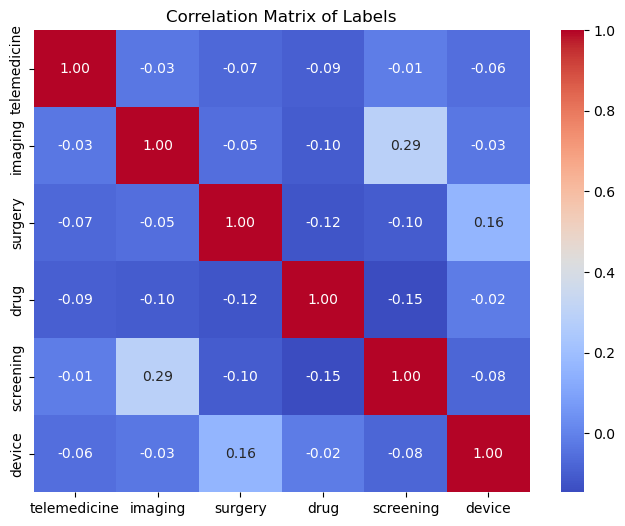

In [5]:
# Label correlation
labels=np.array(cleaned_dataset.iloc[:,2:])#labels from clinical areas - to change this, used 
# Calculate the correlation matrix
correlation_matrix = cleaned_dataset.iloc[:,2:].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Labels")
plt.show()

The matrix show low correlance between the labels. The highest value is 0.19 between oncological and gastrointestinal

----

Following classificators belongs to different methods:
- Problem transformation **PT** (modify the dataset and the problem)
- Algorithm adaptation **AA** (adapt known algorithms to MLC problem)
- Ensemble approaches
- Cost sensitive **CS** (use different cost metrics to describe the costs of any particular misclassified sample, aiming to mini- mize the total cost. Most commonly, these methods are applied to imbalanced learning by associating high misclassifying cost to the minority classes)

In [6]:
# Splitting data

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(embeddings,labels,stratify=labels,test_size=0.2,random_state=42)

# variables for cross-validation & results
kfold_splits = [3, 5, 7]
results = []
tot_results=[]

## 4.1 ml-kNN (AA)

### 4.1.1 Resampler (not working)

In [7]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Custom resampler for multi-label data
class MultiLabelResampler(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy='not majority'):
        self.sampling_strategy = sampling_strategy
        self.resamplers = {}

    def fit(self, X, y):
        self.resamplers = {
            i: RandomOverSampler(sampling_strategy=self.sampling_strategy)
            for i in range(y.shape[1])
        }
        for i, resampler in self.resamplers.items():
            resampler.fit(X, y[:, i])
        return self

    def transform(self, X, y):
        resampled_X, resampled_y = [], []
        for i, resampler in self.resamplers.items():
            X_resampled, y_resampled = resampler.fit_resample(X, y[:, i])
            resampled_X.append(X_resampled)
            resampled_y.append(y_resampled)
        return np.vstack(resampled_X), np.column_stack(resampled_y)
def multilabel_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

In [8]:
# resampler = MultiLabelResampler(sampling_strategy='minority')
# X_resampled, y_resampled = resampler.fit_transform(X_train, y_train)

### **Multilabell kNN**

In [9]:
from skmultilearn.adapt import MLkNN
# Define parameter grid
param_grid = {
    'k': [5,7,9,11,13],  # Number of neighbors
    's': [0.5, 1.0, 3.0]  # Smoothing parameter
}

# Call the function
results_df, best_params = utils.perform_grid_search(
    model_name='MLkNN',
    model_class=MLkNN,
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    kfold_splits=kfold_splits,
    results=results,
    verbose=False,
    output_file="output/"+folder+"/mlknn_grid_search_results.xlsx"
)

# Train the final model with the best parameters
final_model=MLkNN(k=best_params['params'][2],s=best_params['params'][3])
final_model.fit(X_train,y_train)
y_pred=final_model.predict(X_test)
y_prob=final_model.predict_proba(X_test).toarray()
print("\nMLkNN - metrics of final model using best parameters:")
f1,f2,h,r,c,o=utils.get_ml_metrics(y_test,y_pred,y_prob,verbose=1)
tot_results.append([f"MLkNN (K,s):{best_params['params'][2:]}",f1,f2,h,r,c,o])


Performing parameter search with 3-fold Cross Validation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Performing parameter search with 5-fold Cross Validation
Performing parameter search with 7-fold Cross Validation

MLkNN - Best Parameters (<built-in method keys of dict object at 0x3e579c580>) and Score:
params          (MLkNN, 7, 11, 1.0)
Hamming Loss               0.064172
Name: 40, dtype: object

MLkNN - metrics of final model using best parameters:
f1-micro: 0.644
f1-weighted: 0.633
hamming loss: 0.065
ranking loss: 0.071
coverage error: 0.984
one error: 0.625


In [10]:
def plot_roc_curve(y_test, y_prob):
    """
    Plot the ROC curve for each label.
    
    Parameters:
    - y_test: True labels.
    - y_prob: Predicted probabilities.
    """
    
    # Plot ROC curve for each label
    plt.figure(figsize=(10, 6))
    for i in range(y_test.shape[1]):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Label {i} (AUC = {auc_score:.2f})")
    
    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_result_df(params,df):
    """
    Plot the results of the grid search.
    
    Parameters:
    - params: List of parameter names.
    - df: DataFrame with the results.
    """
    
    # Create a new DataFrame with the parameters as columns
    for i, param in enumerate(params):
        df[param] = df['params'].apply(lambda x: x[i])
    
    #df.sort_values(by='Hamming Loss', inplace=True)
    df_=df.groupby('cv split')
    sns.scatterplot(data=df,x=params[2],y='Hamming Loss',hue='cv split')
    
    # df.plot(x='params', y='Hamming Loss', title='Hamming Loss vs. Parameters', figsize=(10, 6))
    # for name, group in df_:
    #     group.plot(x='params', y='Hamming Loss', title=f'Hamming Loss vs. Parameters ({name}-fold CV)', figsize=(10, 6))
    #     plt.show()

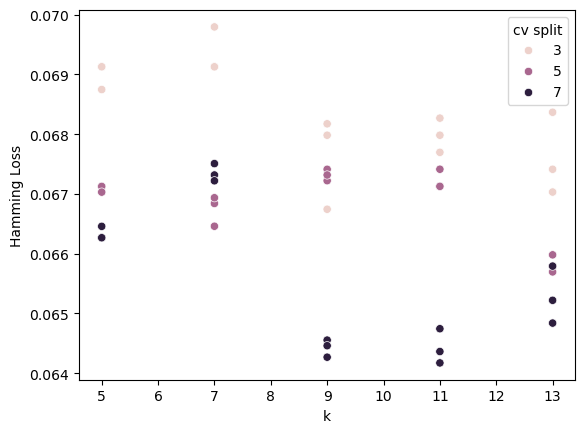

In [11]:
plot_result_df(['Model','cv split','k','s'],results_df)

## 4.2 Value & weight ml - kNN (AA)

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

class VWMLkNN:
    def __init__(self, k=5, alpha=0.5, beta=0.5):
        """
        Initialize VWML-kNN classifier.

        Parameters:
        - k: Number of nearest neighbors.
        - alpha: Weight for the instance contribution in the decision.
        - beta: Weight for the label contribution in the decision.
        """
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Fit the classifier to the training data.

        Parameters:
        - X: Feature matrix of shape (n_samples, n_features).
        - y: Label matrix of shape (n_samples, n_labels).
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        """
        Predict labels for the given data.

        Parameters:
        - X: Feature matrix of shape (n_samples, n_features).

        Returns:
        - Predicted label matrix of shape (n_samples, n_labels).
        """
        n_samples, n_labels = X.shape[0], self.y_train.shape[1]
        predictions = np.zeros((n_samples, n_labels))

        # Compute cosine similarity
        similarities = cosine_similarity(X, self.X_train)

        for i, x in enumerate(X):
            # Get k nearest neighbors and their similarity scores
            neighbor_indices = np.argsort(-similarities[i])[:self.k]
            neighbors = self.y_train[neighbor_indices]
            weights = similarities[i][neighbor_indices]

            # Initialize label scores
            label_scores = np.zeros(n_labels)

            # Calculate label scores
            for j, neighbor in enumerate(neighbors):
                label_scores += (
                    self.alpha * weights[j] * neighbor + self.beta * neighbor
                )

            # Predict based on label scores
            predictions[i] = (label_scores > 0).astype(int)

        return predictions


In [13]:
param_grid = {
    'k' : [1, 3, 5, 7],  # Number of neighbors
    'alpha' : [0.3, 0.5, 0.7],  # Smoothing parameter
    'beta': [0.3, 0.5, 0.7],
}
results=[]
results_df, best_params = utils.perform_grid_search(
    model_name='VWMLkNN',
    model_class=VWMLkNN,
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    kfold_splits=kfold_splits,
    results=results,
    verbose=False,
    output_file="output/"+folder+"/VW-MLkNN_grid_search_results.xlsx"
)

# Train the final model with the best parameters
final_model=VWMLkNN(k=best_params['params'][2],alpha=best_params['params'][3],beta=best_params['params'][4])
final_model.fit(X_train,y_train)
y_pred=final_model.predict(X_test)
print("\nVWMLkNN - metrics of final model using best parameters:")
f1,f2,h,r,c,o=utils.get_ml_metrics(y_test,y_pred,verbose=1)
tot_results.append([f"VW-MLkNN (K,alpha,beta):{best_params['params'][2:]}",f1,f2,h,r,c,o])

Performing parameter search with 3-fold Cross Validation
Performing parameter search with 5-fold Cross Validation
Performing parameter search with 7-fold Cross Validation

VWMLkNN - Best Parameters (<built-in method keys of dict object at 0x3e75709c0>) and Score:
params          (VWMLkNN, 7, 1, 0.3, 0.3)
Hamming Loss                     0.077517
Name: 72, dtype: object

VWMLkNN - metrics of final model using best parameters:
f1-micro: 0.602
f1-weighted: 0.599
hamming loss: 0.083
ranking loss: 0.211
coverage error: 1.709
one error: 0.643


## 4.3 Ranking SVM 

### version 1 (not working)

In [14]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC
from sklearn.utils import shuffle
import numpy as np

# Example: Transform multi-label to ranking data
def transform_to_ranking_data(X, Y, all_labels):
    ranking_data = []
    for x, y_set in zip(X, Y):
        for label in all_labels:
            if label in y_set:
                for other_label in all_labels:
                    if other_label not in y_set:
                        ranking_data.append((x, label, other_label))
    return ranking_data

# Prepare ranking constraints
def prepare_ranking_constraints(ranking_data, feature_map):
    X_rank = []
    y_rank = []
    for x, pos_label, neg_label in ranking_data:
        feature_diff = feature_map[pos_label] - feature_map[neg_label]
        X_rank.append(x @ feature_diff)  # Assuming x is a vector
        y_rank.append(1)  # Positive preference
    return np.array(X_rank), np.array(y_rank)

# Train Ranking SVM (using SVC for demonstration)
def train_ranking_svm(X_rank, y_rank):
    model = SVC(kernel="linear")
    model.fit(X_rank, y_rank)
    return model

# Example usage:
# X = np.random.rand(100, 10)  # Features
# Y = [set(np.random.choice([0, 1, 2], size=2, replace=False)) for _ in range(100)]  # Multi-labels
# all_labels = [0, 1, 2]

# ranking_data = transform_to_ranking_data(X, Y, all_labels)
# X_rank, y_rank = prepare_ranking_constraints(ranking_data, feature_map=np.eye(len(all_labels)))
# model = train_ranking_svm(X_rank, y_rank)


### version 2 (not working)

In [15]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def prepare_ranking_pairs(X, Y):
    """
    Prepare pairwise ranking data for Ranking SVM.
    Args:
        X: Feature matrix (n_samples, n_features)
        Y: Multilabel matrix (n_samples, n_labels)

    Returns:
        Pairwise features and labels.
    """
    X_pairs = []
    Y_pairs = []

    for i in range(len(Y)):
        for j in range(Y.shape[1]):
            for k in range(Y.shape[1]):
                if Y[i, j] > Y[i, k]:
                    X_pairs.append(X[i])
                    Y_pairs.append((j, k))

    return np.array(X_pairs), np.array(Y_pairs)

def ranking_svm(X_pairs, Y_pairs):
    """
    Fit a Ranking SVM.
    Args:
        X_pairs: Pairwise features
        Y_pairs: Pairwise labels

    Returns:
        Model weights.
    """
    n_features = X_pairs.shape[1]
    n_samples = len(Y_pairs)

    P = np.eye(n_features)
    q = np.zeros(n_features)

    # Create inequality constraints for pairwise ranking
    G = []
    h = []
    for i, (j, k) in enumerate(Y_pairs):
        g = np.zeros(n_features)
        g[j] = 1
        g[k] = -1
        G.append(g)
        h.append(-1)

    G = matrix(np.vstack(G))
    h = matrix(np.array(h))
    P = matrix(P)
    q = matrix(q)

    # Solve the quadratic programming problem
    sol = solvers.qp(P, q, G, h)
    return np.array(sol['x']).flatten()

def predict_ranking(X, weights):
    """
    Predict rankings using learned weights.
    Args:
        X: Feature matrix
        weights: Model weights

    Returns:
        Predicted scores.
    """
    return np.dot(X, weights)


In [16]:

# Example usage:

#     # Example dataset
# X = np.random.rand(100, 10)  # Features
# Y = np.random.randint(0, 2, (100, 5))  # Multilabels

#     # Split data
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#     # Prepare ranking pairs
# X_pairs, Y_pairs = prepare_ranking_pairs(X_train, Y_train)

#     # Train Ranking SVM
# weights = ranking_svm(X_pairs, Y_pairs)

#     # Predict on test data
# predictions = predict_ranking(X_test, weights)
# print("Predictions:", predictions)


### MLTSVM --> Multilabel twin SVM (2016)

In [17]:
from skmultilearn.adapt import MLTSVM
param_grid = {'c_k': [2**i for i in range(-5, 5, 2)]}

results=[]
results_df, best_params = utils.perform_grid_search(
    model_name='MLTSVM',
    model_class=MLTSVM,
    X_train=csr_matrix(X_train),
    y_train=csr_matrix(y_train),
    param_grid=param_grid,
    kfold_splits=kfold_splits,
    results=results,
    verbose=False,
    output_file="output/"+folder+"/MLTSVM_grid_search_results.xlsx"
)
# Train the final model with the best parameters
final_model=MLTSVM(c_k=best_params['params'][2])
final_model.fit(csr_matrix(X_train),csr_matrix(y_train))
y_pred=final_model.predict(csr_matrix(X_test))
# y_prob=final_model.predict_proba(csr_matrix(X_test)).toarray()
f1,f2,h,r,c,o=utils.get_ml_metrics(y_test,y_pred,verbose=1)
tot_results.append([f"MLTSVM (c_k):{best_params['params'][2:]}",f1,f2,h,r,c,o])

Performing parameter search with 3-fold Cross Validation
Performing parameter search with 5-fold Cross Validation
Performing parameter search with 7-fold Cross Validation

MLTSVM - Best Parameters (<built-in method keys of dict object at 0x3e5796f40>) and Score:
params          (MLTSVM, 7, 8)
Hamming Loss          0.085718
Name: 14, dtype: object
f1-micro: 0.498
f1-weighted: 0.504
hamming loss: 0.087
ranking loss: 0.317
coverage error: 2.217
one error: 0.757


## 4.4 Binary Relevance classificator (PT)

### label classifier: kNN

In [18]:
from skmultilearn.adapt import BRkNNaClassifier
# Define parameter grid
param_grid = {
    'k': [5,7,9,11,13]  # Number of neighbors
}
results=[]
# Call the function
results_df, best_params = utils.perform_grid_search(
    model_name='BRkNN',
    model_class=BRkNNaClassifier,
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    kfold_splits=kfold_splits,
    results=results,
    verbose=False,
    output_file="output/"+folder+"/brknn_grid_search_results.xlsx"
)

# Train the final model with the best parameters
final_model=BRkNNaClassifier(k=best_params['params'][2])
final_model.fit(X_train,y_train)
y_pred=final_model.predict(X_test)
print("\nBRkNN - metrics of final model using best parameters:")
f1,f2,h,r,c,o=utils.get_ml_metrics(y_test,y_pred,y_pred.toarray(),verbose=1)
tot_results.append([f"BR - kNN (K):{best_params['params'][2:]}",f1,f2,h,r,c,o])

Performing parameter search with 3-fold Cross Validation
Performing parameter search with 5-fold Cross Validation
Performing parameter search with 7-fold Cross Validation

BRkNN - Best Parameters (<built-in method keys of dict object at 0x3e7510800>) and Score:
params          (BRkNN, 7, 9)
Hamming Loss         0.064935
Name: 12, dtype: object

BRkNN - metrics of final model using best parameters:
f1-micro: 0.647
f1-weighted: 0.633
hamming loss: 0.063
ranking loss: 0.226
coverage error: 1.771
one error: 0.652


### label classifier: MultinomialNB & SVC (best) --> modify perform grid search when model is binary relevance

In [19]:
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

#Scaler for MultinomialNB
scaler = MinMaxScaler(feature_range=(0, 10))  # Scale to range [0, 10]
X_scaled = np.round(scaler.fit_transform(X_train)).astype(int)

# List to store results
results = []
# Perform grid search
param_grid = {
    'alpha': [0.3, 0.5, 0.7, 1.]  #  alpha_values= [0.3, 0.5, 0.7, 1.0]
}
# Call the function
results_df, best_params = utils.perform_grid_search(
    model_name='BR_MultinomialNB',
    model_class=MultinomialNB,
    X_train=X_scaled,
    y_train=y_train,
    param_grid=param_grid,
    kfold_splits=kfold_splits,
    results=results,
    verbose=False,
    output_file="output/"+folder+"/BR_mnNB_grid_search_results.xlsx"
)
# Train the final model with the best parameters
Xtest_scaled = np.round(scaler.fit_transform(X_test)).astype(int)
final_model=BinaryRelevance(classifier=MultinomialNB(alpha=best_params['params'][2]), require_dense=[True, True])
final_model.fit(X_scaled,y_train)
y_pred=final_model.predict(Xtest_scaled)
y_prob=final_model.predict_proba(Xtest_scaled).toarray()
f1,f2,h,r,c,o=utils.get_ml_metrics(y_test,y_pred,y_prob,verbose=1)
tot_results.append([f"BR_multinomialNB (alpha):{best_params['params'][2:]}",f1,f2,h,r,c,o])


Performing parameter search with 3-fold Cross Validation
Performing parameter search with 5-fold Cross Validation
Performing parameter search with 7-fold Cross Validation

BR_MultinomialNB - Best Parameters (<built-in method keys of dict object at 0x1060ff640>) and Score:
params          (BR_MultinomialNB, 5, 0.3)
Hamming Loss                      0.081611
Name: 4, dtype: object
f1-micro: 0.630
f1-weighted: 0.655
hamming loss: 0.095
ranking loss: 0.049
coverage error: 0.874
one error: 0.572


In [20]:
# Perform grid search
param_grid = {'kernel': ['linear', 'rbf', 'sigmoid'], 'C': [0.01, 0.1, 1, 10, 100]}
results=[]
results_df, best_params = utils.perform_grid_search(
    model_name='BR_SVC',
    model_class=SVC,
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    kfold_splits=kfold_splits,
    results=results,
    verbose=False,
    output_file="output/"+folder+"/BR_SVC_grid_search_results.xlsx"
)
# Train the final model with the best parameters
final_model=BinaryRelevance(classifier=SVC(kernel=best_params['params'][2],C=best_params['params'][3]), require_dense=[True, True])
final_model.fit(X_train,y_train)
y_pred=final_model.predict(X_test)
f1,f2,h,r,c,o=utils.get_ml_metrics(y_test,y_pred,y_pred.toarray(),verbose=1)
tot_results.append([f"BR_SVC (kernel,C):{best_params['params'][2:]}",f1,f2,h,r,c,o])


Performing parameter search with 3-fold Cross Validation
Performing parameter search with 5-fold Cross Validation
Performing parameter search with 7-fold Cross Validation

BR_SVC - Best Parameters (<built-in method keys of dict object at 0x3e57535c0>) and Score:
params          (BR_SVC, 5, linear, 0.01)
Hamming Loss                     0.050152
Name: 15, dtype: object
f1-micro: 0.710
f1-weighted: 0.694
hamming loss: 0.053
ranking loss: 0.194
coverage error: 1.648
one error: 0.622


## 4.5 RAkELd (CS) - base_classifier: GaussianNB, RandomForest

In [21]:
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD

#Labelsets fot RakelD
# Interventions dataset: ls= 4,5 error in creating powerset groups; 2,3 have higher hamming loss, higher than 6 is ok but same value of hloss, 
# Clinical Areas dataset: error for ls = 5 and >=7

# List to store results
results = []
# Perform grid search
param_grid = {
    'var_smoothing': [1e-12, 1e-9, 1e-8, 1e-7, 1e-6, 1e-3]  
}
# Call the function
results_df, best_params = utils.perform_grid_search(
    model_name='RAkEL_Gaussian',
    model_class=GaussianNB,
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    kfold_splits=kfold_splits,
    results=results,
    verbose=False,
    output_file="output/"+folder+"/RAkEL_Gaussian_grid_search_results.xlsx"
)


# Train the final model with the best parameters
final_model=RakelD(
    base_classifier=GaussianNB(var_smoothing=best_params['params'][2]),
    base_classifier_require_dense=[True, True],
    labelset_size=6 #4,5 error in creating powerset groups; 2,3,4 have higher hamming loss, higher than 6 is ok but same value of hloss, for CA 5, >=7
)
final_model.fit(X_train,y_train)
y_pred=final_model.predict(X_test)
f1,f2,h,r,c,o=utils.get_ml_metrics(y_test,y_pred,y_pred.toarray(),verbose=1)
tot_results.append([f"RAkEL(GaussianNB) : (smoothing):{best_params['params'][2:]}",f1,f2,h,r,c,o])


Performing parameter search with 3-fold Cross Validation
Performing parameter search with 5-fold Cross Validation
Performing parameter search with 7-fold Cross Validation

RAkEL_Gaussian - Best Parameters (<built-in method keys of dict object at 0x3e6030080>) and Score:
params          (RAkEL_Gaussian, 5, 1e-12)
Hamming Loss                      0.078758
Name: 6, dtype: object
f1-micro: 0.659
f1-weighted: 0.663
hamming loss: 0.076
ranking loss: 0.155
coverage error: 1.444
one error: 0.597


In [22]:
from sklearn.ensemble import RandomForestClassifier

# List to store results
results = []
# Perform grid search
param_grid = {
    'n_estimators': [10,50,100,300,500] 
}
# Call the function
results_df, best_params = utils.perform_grid_search(
    model_name='RAkEL_RandomForest',
    model_class=RandomForestClassifier,
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    kfold_splits=kfold_splits,
    results=results,
    verbose=False,
    output_file="output/"+folder+"/RAkEL_RandmForest_grid_search_results.xlsx"
)


# Train the final model with the best parameters
final_model=RakelD(
    base_classifier=RandomForestClassifier(n_estimators=best_params['params'][2]),
    base_classifier_require_dense=[True, True],
    labelset_size=6 #4,5 error in creating powerset groups; 2,3,4 have higher hamming loss, higher than 6 is ok but same value of hloss, for CA 5, >=7
)
final_model.fit(X_train,y_train)
y_pred=final_model.predict(X_test)
f1,f2,h,r,c,o=utils.get_ml_metrics(y_test,y_pred,y_pred.toarray(),verbose=1)
tot_results.append([f"RAkEL(RandomForest) : (n_estimators):{best_params['params'][2:]}",f1,f2,h,r,c,o])

Performing parameter search with 3-fold Cross Validation
Performing parameter search with 5-fold Cross Validation
Performing parameter search with 7-fold Cross Validation

RAkEL_RandomForest - Best Parameters (<built-in method keys of dict object at 0x3e6c43bc0>) and Score:
params          (RAkEL_RandomForest, 5, 100)
Hamming Loss                        0.068648
Name: 7, dtype: object
f1-micro: 0.547
f1-weighted: 0.494
hamming loss: 0.069
ranking loss: 0.311
coverage error: 2.199
one error: 0.716


In [23]:
#data_Int_not_labeled.to_excel('interventions_not_labeled.xlsx')
pd.set_option("display.float_format", "{:.4f}".format)

from IPython.display import display
from tabulate import tabulate
res_df=pd.DataFrame(tot_results,columns=['model','f1-micro','f1-weighted','hamming_loss','ranking_loss','coverage_error','One_error'])
res_df.sort_values(by='hamming_loss',inplace=True)
#print(tabulate(res_df, headers=['model','f1-micro','f1-weighted','hamming_loss','ranking_loss','coverage_error','One_error'],tablefmt='pretty', floatfmt=".3f"))
print("Results ordered by Hamming Loss")
display(res_df)
res_df.to_excel("output/"+folder+"/Interventions_full_results.xlsx")

Results ordered by Hamming Loss


,model,f1-micro,f1-weighted,hamming_loss,ranking_loss,coverage_error,One_error
5,"BR_SVC (kernel,C):('linear', 0.01)",0.7101,0.6945,0.0526,0.1940,1.6476,0.6224
3,"BR - kNN (K):(9,)",0.6467,0.6331,0.0629,0.2264,1.7712,0.6522
0,"MLkNN (K,s):(11, 1.0)",0.6444,0.6328,0.0648,0.0713,0.9840,0.6247
7,"RAkEL(RandomForest) : (n_estimators):(100,)",0.5473,0.4938,0.0694,0.3108,2.1991,0.7162
6,"RAkEL(GaussianNB) : (smoothing):(1e-12,)",0.6587,0.6634,0.0759,0.1548,1.4439,0.5973
1,"VW-MLkNN (K,alpha,beta):(1, 0.3, 0.3)",0.6018,0.5995,0.0828,0.2113,1.7094,0.6430
2,"MLTSVM (c_k):(8,)",0.4978,0.5044,0.0870,0.3173,2.2174,0.7574
4,"BR_multinomialNB (alpha):(0.3,)",0.6300,0.6553,0.0950,0.0490,0.8741,0.5721
